# Random Search

# All Libraries (Must execute)

In [1]:
# Numpy, pandas, matplotlib, statistics, os, bayes_opt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import os
import time
from bayes_opt import BayesianOptimization


# Sklearn

from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV


# Tensorflow & keras


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, InputLayer, ReLU, PReLU, LeakyReLU, Softmax
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import BayesianOptimization
from kerastuner.tuners import Hyperband

<ipython-input-1-551cc858abc6>:43: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Dataset (Must execute)

In [2]:
df = pd.read_csv('D:\\Drive 1\\MS\\Masters\\Additive Manufacturing\\AI in AM\\1\\Data 3.csv', header = 0)
df.head()

,Sr. #,Power,Speed,Thickness,Spacing,Density
0,1,25.0,700.0,0.02,0.08,76.02
1,2,25.0,700.0,0.02,0.04,91.22
2,3,100.0,1700.0,0.02,0.06,98.12
3,4,80.0,1500.0,0.02,0.04,98.33
4,5,80.0,700.0,0.02,0.08,99.02


In [3]:
df.isnull().any()

Sr. #        False
Power        False
Speed        False
Thickness    False
Spacing      False
Density      False
dtype: bool

In [4]:
# Conversion into numpy array for further processing
X = df.iloc[:,1:5]
X = pd.DataFrame(X)
Y = df.iloc[:,5]
X_num = X.values
Y_num = Y.values

# Train-test split (Must execute)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split (X,Y, test_size = 0.3, random_state = 50)
print(X_train.shape)
print(X_test.shape)

(58, 4)
(26, 4)


# Feature Scaling (Must execute)

(i) Standardization &
(ii) Normalization

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaling = StandardScaler ()

In [7]:
X_train_scaled = scaling.fit_transform(X_train)
X_test_scaled = scaling.fit_transform(X_test)
X_scaled = scaling.fit_transform(X)

In [8]:
min_max=MinMaxScaler()
X_train_normalized=pd.DataFrame(min_max.fit_transform(X_train))
X_test_normalized=pd.DataFrame(min_max.fit_transform(X_test))
X_train_normalized.head()

,0,1,2,3
0,0.429272,0.311805,0.000000,0.20
1,0.306623,0.067761,1.000000,0.80
2,0.306623,0.004764,1.000000,0.71
3,0.511038,0.177343,0.333333,1.00
4,0.511038,0.258867,0.666667,0.40


In [9]:
X_test_normalized.head()

,0,1,2,3
0,0.272727,0.000000,1.000000,0.800
1,0.545455,0.468461,0.333333,0.800
2,0.889455,0.597645,0.000000,0.678
3,0.565091,0.597645,0.000000,0.678
4,0.636364,0.537426,1.000000,0.700


# Hyperparameter Optimization 1
Random search using Keras Tuner

In [14]:
def build_model_1(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.SGD(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [15]:
tuner_1 = RandomSearch(
    build_model_1,
    objective='val_mean_absolute_error',
    max_trials=1,
    executions_per_trial=1,
    overwrite = True)

In [16]:
tuner_1.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [17]:
tuner_1.search(X_train_scaled, Y_train,
             epochs=5000,
             validation_data=(X_test_scaled, Y_test))

Trial 1 Complete [00h 02m 49s]
val_mean_absolute_error: 0.9353924989700317

Best val_mean_absolute_error So Far: 0.9353924989700317
Total elapsed time: 00h 02m 49s
INFO:tensorflow:Oracle triggered exit


In [18]:
models = tuner_1.get_best_models(num_models=1)

In [19]:
tuner_1.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 9
units_0: 288
learning_rate: 0.01
units_1: 32
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
Score: 0.9353924989700317


# Model Implementation in Keras

In [20]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
opt = SGD(learning_rate = 0.01, clipnorm=1.0)    
model = Sequential ()
model.add(InputLayer(X_train.shape[1]))
model.add(Dense(288,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer = opt)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 288)               1440      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                9248      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_16 (Dense)             (None, 32)               

In [24]:
history = model.fit(X_train_scaled, Y_train, verbose = 1, epochs=4000, batch_size = 32, validation_data = (X_test_scaled,Y_test))

Epoch 1/4000
2/2 [==============================] - 0s 171ms/step - loss: 97.3018 - val_loss: 97.2501
Epoch 2/4000
2/2 [==============================] - 0s 15ms/step - loss: 97.2552 - val_loss: 97.2096
Epoch 3/4000
2/2 [==============================] - 0s 13ms/step - loss: 97.2151 - val_loss: 97.1672
Epoch 4/4000
2/2 [==============================] - 0s 13ms/step - loss: 97.1709 - val_loss: 97.1242
Epoch 5/4000
2/2 [==============================] - 0s 15ms/step - loss: 97.1301 - val_loss: 97.0820
Epoch 6/4000
2/2 [==============================] - 0s 13ms/step - loss: 97.0869 - val_loss: 97.0400
Epoch 7/4000
2/2 [==============================] - 0s 13ms/step - loss: 97.0454 - val_loss: 96.9974
Epoch 8/4000
2/2 [==============================] - 0s 16ms/step - loss: 97.0025 - val_loss: 96.9544
Epoch 9/4000
2/2 [==============================] - 0s 14ms/step - loss: 96.9589 - val_loss: 96.9105
Epoch 10/4000
2/2 [==============================] - 0s 13ms/step - loss: 96.9133 - val_lo

2/2 [==============================] - 0s 12ms/step - loss: 5.3442 - val_loss: 5.9082
Epoch 163/4000
2/2 [==============================] - 0s 12ms/step - loss: 4.4491 - val_loss: 5.7177
Epoch 164/4000
2/2 [==============================] - 0s 13ms/step - loss: 4.6417 - val_loss: 5.8021
Epoch 165/4000
2/2 [==============================] - 0s 11ms/step - loss: 4.4239 - val_loss: 5.7157
Epoch 166/4000
2/2 [==============================] - 0s 11ms/step - loss: 4.4280 - val_loss: 5.8188
Epoch 167/4000
2/2 [==============================] - 0s 12ms/step - loss: 5.7020 - val_loss: 5.8635
Epoch 168/4000
2/2 [==============================] - 0s 14ms/step - loss: 4.3473 - val_loss: 5.7885
Epoch 169/4000
2/2 [==============================] - 0s 11ms/step - loss: 5.1840 - val_loss: 5.9108
Epoch 170/4000
2/2 [==============================] - 0s 11ms/step - loss: 4.8801 - val_loss: 5.9671
Epoch 171/4000
2/2 [==============================] - 0s 13ms/step - loss: 5.0492 - val_loss: 5.9351
Epoch

2/2 [==============================] - 0s 12ms/step - loss: 4.1476 - val_loss: 5.3109
Epoch 324/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.6613 - val_loss: 5.3583
Epoch 325/4000
2/2 [==============================] - 0s 10ms/step - loss: 4.0979 - val_loss: 5.3062
Epoch 326/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.6215 - val_loss: 5.3896
Epoch 327/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.7637 - val_loss: 5.3449
Epoch 328/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.8157 - val_loss: 5.6192
Epoch 329/4000
2/2 [==============================] - 0s 10ms/step - loss: 4.2138 - val_loss: 5.4572
Epoch 330/4000
2/2 [==============================] - 0s 10ms/step - loss: 4.0647 - val_loss: 5.4564
Epoch 331/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.6864 - val_loss: 5.4823
Epoch 332/4000
2/2 [==============================] - 0s 10ms/step - loss: 4.0738 - val_loss: 5.3463
Epoch

2/2 [==============================] - 0s 12ms/step - loss: 3.9785 - val_loss: 5.2821
Epoch 405/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.8815 - val_loss: 5.3323
Epoch 406/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.6589 - val_loss: 5.3030
Epoch 407/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.5870 - val_loss: 5.3671
Epoch 408/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.9815 - val_loss: 5.3652
Epoch 409/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.8650 - val_loss: 5.3236
Epoch 410/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.8958 - val_loss: 5.3237
Epoch 411/4000
2/2 [==============================] - 0s 10ms/step - loss: 4.0060 - val_loss: 5.4373
Epoch 412/4000
2/2 [==============================] - 0s 10ms/step - loss: 4.1716 - val_loss: 5.4097
Epoch 413/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.8533 - val_loss: 5.2629
Epoch

Epoch 566/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.5443 - val_loss: 5.7102
Epoch 567/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.8566 - val_loss: 5.5280
Epoch 568/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.6060 - val_loss: 5.4945
Epoch 569/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.5338 - val_loss: 5.3916
Epoch 570/4000
2/2 [==============================] - 0s 12ms/step - loss: 4.0442 - val_loss: 5.2834
Epoch 571/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.5047 - val_loss: 5.3787
Epoch 572/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.3023 - val_loss: 5.1746
Epoch 573/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.5493 - val_loss: 5.1932
Epoch 574/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.6753 - val_loss: 5.2227
Epoch 575/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.5476 - val_los

2/2 [==============================] - 0s 10ms/step - loss: 3.5133 - val_loss: 5.4754
Epoch 648/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.4780 - val_loss: 5.4706
Epoch 649/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.9026 - val_loss: 5.1873
Epoch 650/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.4016 - val_loss: 5.3239
Epoch 651/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.5682 - val_loss: 5.3854
Epoch 652/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.6740 - val_loss: 5.3266
Epoch 653/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.4860 - val_loss: 5.2328
Epoch 654/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.6103 - val_loss: 5.1627
Epoch 655/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.5835 - val_loss: 5.2937
Epoch 656/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.8482 - val_loss: 5.2872
Epoch

Epoch 728/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.3434 - val_loss: 5.5328
Epoch 729/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2140 - val_loss: 5.3400
Epoch 730/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.6651 - val_loss: 5.5899
Epoch 731/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.3581 - val_loss: 5.5822
Epoch 732/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.6848 - val_loss: 5.5304
Epoch 733/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.5461 - val_loss: 5.3409
Epoch 734/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.6386 - val_loss: 5.3449
Epoch 735/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.4365 - val_loss: 5.5047
Epoch 736/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.5237 - val_loss: 5.5589
Epoch 737/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.4402 - val_los

Epoch 809/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.7238 - val_loss: 5.4217
Epoch 810/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.9245 - val_loss: 5.4559
Epoch 811/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.0344 - val_loss: 5.5291
Epoch 812/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.6526 - val_loss: 5.6173
Epoch 813/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.4903 - val_loss: 5.7620
Epoch 814/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.4382 - val_loss: 5.6833
Epoch 815/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.7009 - val_loss: 5.4121
Epoch 816/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.5944 - val_loss: 5.3594
Epoch 817/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.1661 - val_loss: 5.3710
Epoch 818/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.3672 - val_los

Epoch 971/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.5121 - val_loss: 5.2119
Epoch 972/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.7138 - val_loss: 5.4143
Epoch 973/4000
2/2 [==============================] - ETA: 0s - loss: 3.024 - 0s 10ms/step - loss: 3.2474 - val_loss: 5.1191
Epoch 974/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.3784 - val_loss: 5.4562
Epoch 975/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2617 - val_loss: 5.3740
Epoch 976/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.4670 - val_loss: 5.4209
Epoch 977/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.3120 - val_loss: 5.4426
Epoch 978/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.6817 - val_loss: 5.1805
Epoch 979/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.3395 - val_loss: 4.8797
Epoch 980/4000
2/2 [==============================] - 0s 14ms/step 

2/2 [==============================] - 0s 13ms/step - loss: 3.6613 - val_loss: 5.1558
Epoch 1132/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.5093 - val_loss: 5.3343
Epoch 1133/4000
2/2 [==============================] - ETA: 0s - loss: 3.092 - 0s 14ms/step - loss: 3.4671 - val_loss: 5.2713
Epoch 1134/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.0854 - val_loss: 5.1546
Epoch 1135/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.4252 - val_loss: 5.1629
Epoch 1136/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.5996 - val_loss: 5.0202
Epoch 1137/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.5095 - val_loss: 4.9931
Epoch 1138/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.2100 - val_loss: 4.7856
Epoch 1139/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.5073 - val_loss: 5.0693
Epoch 1140/4000
2/2 [==============================] - 0s 13ms/step - loss

2/2 [==============================] - 0s 11ms/step - loss: 3.6395 - val_loss: 5.3095
Epoch 1292/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.4442 - val_loss: 5.4303
Epoch 1293/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2468 - val_loss: 5.6205
Epoch 1294/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.4518 - val_loss: 5.7667
Epoch 1295/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.5257 - val_loss: 5.5699
Epoch 1296/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2575 - val_loss: 5.3601
Epoch 1297/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.4063 - val_loss: 5.4055
Epoch 1298/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.5145 - val_loss: 5.4263
Epoch 1299/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.3760 - val_loss: 5.6454
Epoch 1300/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.0289 - val_loss: 5.56

2/2 [==============================] - 0s 13ms/step - loss: 3.5270 - val_loss: 5.2299
Epoch 1452/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.1878 - val_loss: 5.5145
Epoch 1453/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.3772 - val_loss: 5.6238
Epoch 1454/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1028 - val_loss: 5.5055
Epoch 1455/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1161 - val_loss: 5.2876
Epoch 1456/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.2082 - val_loss: 5.2879
Epoch 1457/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.3113 - val_loss: 5.3984
Epoch 1458/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.4843 - val_loss: 5.5053
Epoch 1459/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2384 - val_loss: 5.3163
Epoch 1460/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2928 - val_loss: 5.2

Epoch 1611/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.4878 - val_loss: 5.5778
Epoch 1612/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.2750 - val_loss: 5.5034
Epoch 1613/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.2432 - val_loss: 5.4787
Epoch 1614/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.3711 - val_loss: 5.5876
Epoch 1615/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.2549 - val_loss: 5.4153
Epoch 1616/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.2866 - val_loss: 5.4540
Epoch 1617/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.1671 - val_loss: 5.3732
Epoch 1618/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.2545 - val_loss: 5.4337
Epoch 1619/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.2824 - val_loss: 5.2035
Epoch 1620/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.3812

2/2 [==============================] - 0s 9ms/step - loss: 3.1009 - val_loss: 5.1633
Epoch 1772/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.4053 - val_loss: 5.2675
Epoch 1773/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.3197 - val_loss: 5.1838
Epoch 1774/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.4371 - val_loss: 5.0712
Epoch 1775/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.4355 - val_loss: 5.1377
Epoch 1776/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2666 - val_loss: 5.1574
Epoch 1777/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.3567 - val_loss: 5.3036
Epoch 1778/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.2164 - val_loss: 5.2530
Epoch 1779/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.5812 - val_loss: 5.1472
Epoch 1780/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.3561 - val_loss: 5.093

2/2 [==============================] - 0s 10ms/step - loss: 3.4033 - val_loss: 5.4668
Epoch 1932/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.4020 - val_loss: 5.2688
Epoch 1933/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.3812 - val_loss: 5.3495
Epoch 1934/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.4198 - val_loss: 5.4662
Epoch 1935/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.3693 - val_loss: 5.4385
Epoch 1936/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.3295 - val_loss: 5.3170
Epoch 1937/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.2987 - val_loss: 5.3916
Epoch 1938/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.1614 - val_loss: 5.1661
Epoch 1939/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.5950 - val_loss: 5.5074
Epoch 1940/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.2399 - val_loss: 5.608

2/2 [==============================] - 0s 10ms/step - loss: 3.0030 - val_loss: 5.0400
Epoch 2092/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1727 - val_loss: 4.8051
Epoch 2093/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.0658 - val_loss: 4.8959
Epoch 2094/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.4967 - val_loss: 5.1439
Epoch 2095/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1203 - val_loss: 5.0899
Epoch 2096/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.5098 - val_loss: 5.0107
Epoch 2097/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1349 - val_loss: 5.0100
Epoch 2098/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.3614 - val_loss: 5.1347
Epoch 2099/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.4159 - val_loss: 5.0144
Epoch 2100/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.3711 - val_loss: 5.0569

2/2 [==============================] - 0s 15ms/step - loss: 3.2432 - val_loss: 5.5107
Epoch 2252/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.3505 - val_loss: 5.5181
Epoch 2253/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.1777 - val_loss: 5.2975
Epoch 2254/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.2057 - val_loss: 5.4574
Epoch 2255/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2336 - val_loss: 5.7176
Epoch 2256/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.0395 - val_loss: 5.6001
Epoch 2257/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.1884 - val_loss: 5.4775
Epoch 2258/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2062 - val_loss: 5.5864
Epoch 2259/4000
2/2 [==============================] - 0s 10ms/step - loss: 2.9460 - val_loss: 5.6313
Epoch 2260/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1562 - val_loss: 5.588

2/2 [==============================] - 0s 14ms/step - loss: 3.2645 - val_loss: 5.1390
Epoch 2412/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.3157 - val_loss: 5.4391
Epoch 2413/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2244 - val_loss: 5.3647
Epoch 2414/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.2917 - val_loss: 5.4020
Epoch 2415/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2480 - val_loss: 5.6131
Epoch 2416/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.2581 - val_loss: 5.3682
Epoch 2417/4000
2/2 [==============================] - ETA: 0s - loss: 3.296 - 0s 12ms/step - loss: 3.4862 - val_loss: 5.2851
Epoch 2418/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.1730 - val_loss: 5.1821
Epoch 2419/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.3291 - val_loss: 5.2122
Epoch 2420/4000
2/2 [==============================] - 0s 12ms/step - loss

2/2 [==============================] - 0s 11ms/step - loss: 3.1168 - val_loss: 5.2633
Epoch 2492/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.3172 - val_loss: 5.2218
Epoch 2493/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.2874 - val_loss: 5.4632
Epoch 2494/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.2587 - val_loss: 5.1363
Epoch 2495/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1869 - val_loss: 5.0331
Epoch 2496/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.4674 - val_loss: 5.0628
Epoch 2497/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.1085 - val_loss: 5.3807
Epoch 2498/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2192 - val_loss: 5.2524
Epoch 2499/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2273 - val_loss: 5.0325
Epoch 2500/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.2818 - val_loss: 5.1

2/2 [==============================] - 0s 11ms/step - loss: 3.3934 - val_loss: 5.6318
Epoch 2652/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.4074 - val_loss: 5.4570
Epoch 2653/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.3491 - val_loss: 5.1769
Epoch 2654/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.3836 - val_loss: 5.2099
Epoch 2655/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.2262 - val_loss: 5.2623
Epoch 2656/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.4144 - val_loss: 5.3348
Epoch 2657/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.3013 - val_loss: 5.2819
Epoch 2658/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.0759 - val_loss: 5.3273
Epoch 2659/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.0425 - val_loss: 5.3760
Epoch 2660/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.1167 - val_loss: 5.3

2/2 [==============================] - 0s 9ms/step - loss: 3.1516 - val_loss: 5.1824
Epoch 2812/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.2947 - val_loss: 5.2800
Epoch 2813/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.4669 - val_loss: 5.2018
Epoch 2814/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.2478 - val_loss: 5.2159
Epoch 2815/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.5218 - val_loss: 5.0287
Epoch 2816/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1822 - val_loss: 5.2354
Epoch 2817/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.3045 - val_loss: 5.2294
Epoch 2818/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1934 - val_loss: 5.2405
Epoch 2819/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2531 - val_loss: 5.1301
Epoch 2820/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2501 - val_loss: 5.0365
Ep

Epoch 2892/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.3103 - val_loss: 5.2523
Epoch 2893/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2841 - val_loss: 5.2199
Epoch 2894/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2453 - val_loss: 5.1618
Epoch 2895/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1961 - val_loss: 4.9897
Epoch 2896/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1945 - val_loss: 5.2106
Epoch 2897/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1719 - val_loss: 5.4191
Epoch 2898/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.0108 - val_loss: 5.2434
Epoch 2899/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.0911 - val_loss: 5.1752
Epoch 2900/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2140 - val_loss: 5.2528
Epoch 2901/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.2946 -

2/2 [==============================] - 0s 13ms/step - loss: 3.5147 - val_loss: 5.5234
Epoch 3053/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.2394 - val_loss: 5.5315
Epoch 3054/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.1976 - val_loss: 5.4428
Epoch 3055/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.2578 - val_loss: 5.6003
Epoch 3056/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.3949 - val_loss: 5.5883
Epoch 3057/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.1630 - val_loss: 5.6759
Epoch 3058/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.3905 - val_loss: 5.6163
Epoch 3059/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.3636 - val_loss: 5.4325
Epoch 3060/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2484 - val_loss: 5.5120
Epoch 3061/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.3610 - val_loss: 5.4

Epoch 3212/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.2514 - val_loss: 5.3655
Epoch 3213/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2481 - val_loss: 5.3672
Epoch 3214/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.5008 - val_loss: 5.2278
Epoch 3215/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.3116 - val_loss: 5.1573
Epoch 3216/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.2009 - val_loss: 5.1833
Epoch 3217/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.1742 - val_loss: 5.1392
Epoch 3218/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.2473 - val_loss: 5.1440
Epoch 3219/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.1517 - val_loss: 5.5394
Epoch 3220/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2242 - val_loss: 5.5880
Epoch 3221/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.1235

2/2 [==============================] - 0s 10ms/step - loss: 3.4001 - val_loss: 5.2174
Epoch 3373/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2642 - val_loss: 5.2790
Epoch 3374/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.2106 - val_loss: 5.0945
Epoch 3375/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2080 - val_loss: 4.9549
Epoch 3376/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.3089 - val_loss: 5.1557
Epoch 3377/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1899 - val_loss: 5.0432
Epoch 3378/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1744 - val_loss: 5.1367
Epoch 3379/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1418 - val_loss: 5.2439
Epoch 3380/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2502 - val_loss: 5.4515
Epoch 3381/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2209 - val_loss: 5.54

Epoch 3453/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2798 - val_loss: 5.4782
Epoch 3454/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.0912 - val_loss: 5.3125
Epoch 3455/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.3335 - val_loss: 5.3961
Epoch 3456/4000
2/2 [==============================] - 0s 14ms/step - loss: 3.2428 - val_loss: 5.3647
Epoch 3457/4000
2/2 [==============================] - 0s 15ms/step - loss: 3.3672 - val_loss: 5.4682
Epoch 3458/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.3376 - val_loss: 5.5645
Epoch 3459/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2440 - val_loss: 5.6549
Epoch 3460/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.1582 - val_loss: 5.6152
Epoch 3461/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1306 - val_loss: 5.3936
Epoch 3462/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.3760

2/2 [==============================] - 0s 16ms/step - loss: 3.2061 - val_loss: 5.4562
Epoch 3614/4000
2/2 [==============================] - 0s 13ms/step - loss: 3.0401 - val_loss: 5.2919
Epoch 3615/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1181 - val_loss: 5.3594
Epoch 3616/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2774 - val_loss: 5.2863
Epoch 3617/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.0560 - val_loss: 5.1944
Epoch 3618/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1417 - val_loss: 5.1546
Epoch 3619/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1451 - val_loss: 5.3510
Epoch 3620/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.2682 - val_loss: 5.3826
Epoch 3621/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.3664 - val_loss: 5.4252
Epoch 3622/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.3738 - val_loss: 5.3302
E

Epoch 3774/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.2192 - val_loss: 5.0455
Epoch 3775/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.2059 - val_loss: 4.9988
Epoch 3776/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.3744 - val_loss: 5.1313
Epoch 3777/4000
2/2 [==============================] - 0s 12ms/step - loss: 3.1750 - val_loss: 5.0037
Epoch 3778/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1400 - val_loss: 5.1622
Epoch 3779/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.2699 - val_loss: 5.2936
Epoch 3780/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1975 - val_loss: 5.0357
Epoch 3781/4000
2/2 [==============================] - 0s 11ms/step - loss: 3.2329 - val_loss: 5.0843
Epoch 3782/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1433 - val_loss: 5.3118
Epoch 3783/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1036 - val

2/2 [==============================] - 0s 9ms/step - loss: 3.2783 - val_loss: 5.5041
Epoch 3935/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.2663 - val_loss: 5.3682
Epoch 3936/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2509 - val_loss: 5.2530
Epoch 3937/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1521 - val_loss: 5.1895
Epoch 3938/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.1839 - val_loss: 5.3141
Epoch 3939/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.3031 - val_loss: 5.2598
Epoch 3940/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.0481 - val_loss: 5.1552
Epoch 3941/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.2282 - val_loss: 5.2847
Epoch 3942/4000
2/2 [==============================] - 0s 10ms/step - loss: 3.1463 - val_loss: 5.2898
Epoch 3943/4000
2/2 [==============================] - 0s 9ms/step - loss: 3.0403 - val_loss: 5.2430
Epo

In [25]:
Y_predicted = model.predict (X_test_scaled,verbose =1)

1/1 [==============================] - 0s 1ms/step


# Results Plotting

<ipython-input-27-2aed71b021c6>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(epochs, loss, 'y', Label='Training Loss')
<ipython-input-27-2aed71b021c6>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(epochs, val_loss, 'r', Label='Test Loss')


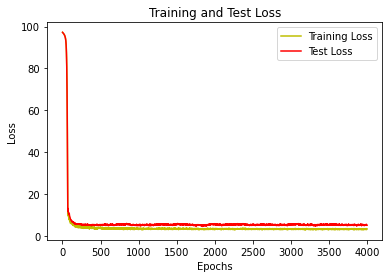

In [27]:
loss = history.history['loss']
val_loss = history.history ['val_loss']
epochs = range (1, len(loss)+1)
plt.plot(epochs, loss, 'y', Label='Training Loss')
plt.plot(epochs, val_loss, 'r', Label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training and Test Loss.jpg')
plt.show()

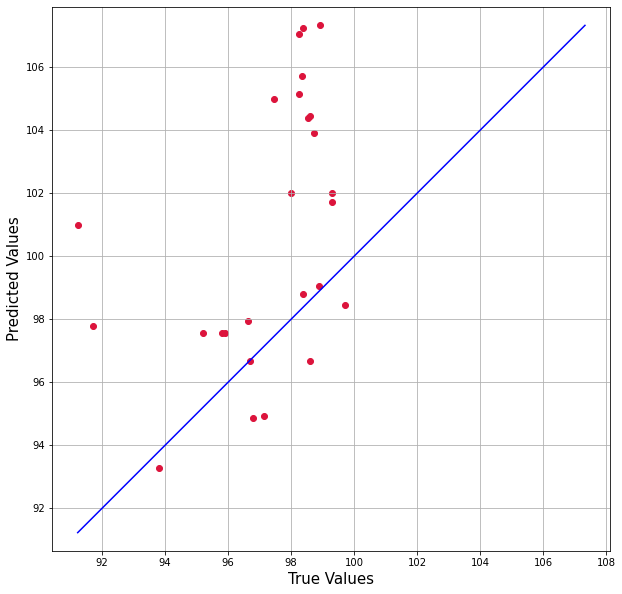

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test, Y_predicted, c='crimson')
p1 = max(max(Y_predicted), max(Y_test))
p2 = min(min(Y_predicted), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.grid()
plt.savefig('True Values vs Predicted Values.jpg')
plt.show()

# 5-Fold Cross Validation

In [30]:
df = pd.read_csv('D:\\Drive 1\\MS\\Masters\\Additive Manufacturing\\AI in AM\\1\\Data 3.csv', header =0)
X = df.iloc[:,1:5]
X = pd.DataFrame(X)
Y = df.iloc[:,5]
Y = pd.DataFrame (Y)
X = X.values
Y = Y.values

In [31]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
kf=KFold(5, shuffle = True, random_state=50)
OOS_y = []
OOS_prediction = []
score_list = []
fold = 0
for train, test in kf.split(X):
    fold = fold+1
    opt = SGD(learning_rate = 0.01, clipnorm=1.0)
    X_train = X[train]
    Y_train = Y[train]
    X_test = X[test]
    Y_test = Y[test]
    model = Sequential ()
    model.add(InputLayer(X_train.shape[1]))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = opt)
    model.fit(X_train, Y_train, epochs=4000, verbose = 0, batch_size = 32, validation_data = (X_test, Y_test))
    prediction = model.predict(X_test)
    OOS_y.append(Y_test)
    OOS_prediction.append(prediction)
    score = np.sqrt(metrics.mean_squared_error(prediction, Y_test))
    score_list.append(score)
    print (f"Final score (RMSE): {score}")
mean = statistics.mean(score_list)
print("Mean of 5-fold cross validation is equal to {}".format(mean))
OOS_y = np.concatenate (OOS_y)    
OOS_prediction = np.concatenate (OOS_prediction)
OOS_y = pd.DataFrame(OOS_y)
OOS_prediction = pd.DataFrame (OOS_prediction)
OOS = pd.concat ([df, OOS_y, OOS_prediction], axis = 1)

Final score (RMSE): 3.315032124782703
Final score (RMSE): 6.408648175628802
Final score (RMSE): 4.204325485594352
Final score (RMSE): 1.982110064541806
Final score (RMSE): 14.552526319621316
Mean of 5-fold cross validation is equal to 6.092528434033796


In [34]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
kf=KFold(5, shuffle = True, random_state=50)
OOS_y = []
OOS_prediction = []
score_list = []
fold = 0
for train, test in kf.split(X):
    fold = fold+1
    opt = SGD(learning_rate = 0.01, clipnorm=1.0)
    X_train = X[train]
    Y_train = Y[train]
    X_test = X[test]
    Y_test = Y[test]
    model = Sequential ()
    model.add(InputLayer(X_train.shape[1]))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32,activation='relu', bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(1))
    model.compile(loss = 'mean_absolute_error', optimizer = opt)
    model.fit(X_train, Y_train, epochs=4000, verbose = 0, batch_size = 32, validation_data = (X_test, Y_test))
    prediction = model.predict(X_test)
    OOS_y.append(Y_test)
    OOS_prediction.append(prediction)
    score = metrics.mean_absolute_error(prediction, Y_test)
    score_list.append(score)
    print (f"Final score (MAE): {score}")
mean = statistics.mean(score_list)
print("Mean of 5-fold cross validation is equal to {}".format(mean))
OOS_y = np.concatenate (OOS_y)    
OOS_prediction = np.concatenate (OOS_prediction)
OOS_y = pd.DataFrame(OOS_y)
OOS_prediction = pd.DataFrame (OOS_prediction)
OOS = pd.concat ([df, OOS_y, OOS_prediction], axis = 1)

Final score (MAE): 6.240443743537453
Final score (MAE): 2.197983721564798
Final score (MAE): 13.719997262393727
Final score (MAE): 1.696519524069393
Final score (MAE): 10.64172176361084
Mean of 5-fold cross validation is equal to 6.899333203035242
